In [1]:
pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp312-cp312-linux_x86_64.whl size=567858 sha256=08d75e8490d6ff679b23a1d259e2389f716d23f8942369b5cdb260268eb7472d
  Stored in directory: /root/.cache/pip/wheels/ab/d0/26/b82cb0f49ae73e5e6bba4e8462fff2c9851d7bd2ec64f8891e
Successfully built fastdtw


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

In [5]:
train = pd.read_csv('/content/train.csv')
submission = pd.read_csv('/content/sample_submission.csv')

In [6]:
monthly = train.groupby(['item_id', 'year', 'month']).agg({
    'value': 'sum',
    'weight': 'sum',
    'quantity': 'sum',
    'hs4': 'first'
}).reset_index()

monthly['year_month'] = pd.to_datetime(
    monthly['year'].astype(str) + '-' + monthly['month'].astype(str),
    format='%Y-%m'
)

pivot_value = monthly.pivot_table(
    index='year_month',
    columns='item_id',
    values='value',
    fill_value=0
).sort_index()

# Transpose: item을 index로 (예시 코드 형식)
pivot = pivot_value.T  # (100 items × 43 months)

pivot.head(5)

year_month,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0
APQGTRMF,383999.0,512813.0,217064.0,470398.0,539873.0,582317.0,759980.0,216019.0,537693.0,205326.0,...,683581.0,2147.0,0.0,25013.0,77.0,20741.0,2403.0,3543.0,32430.0,40608.0
ATLDMDBO,143097177.0,103568323.0,118403737.0,121873741.0,115024617.0,65716075.0,146216818.0,97552978.0,72341427.0,87454167.0,...,60276050.0,30160198.0,42613728.0,64451013.0,38667429.0,29354408.0,42450439.0,37136720.0,32181798.0,57090235.0


In [7]:
from scipy.stats import pearsonr

def safe_corr_with_pvalue(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0, 1.0
    corr, p_value = pearsonr(x, y)
    return float(corr), float(p_value) # 피어슨 상관계수, p-value

In [8]:
def calculate_score_advanced(corr, p_value, lag):
    """
    상관계수(70%) + p-value(20%) + lag(10%)
    """
    # 상관계수 (0~70점)
    corr_score = abs(corr) * 70

    # 통계적 유의성 (0~20점)
    if p_value < 0.001:
        sig_score = 20
    elif p_value < 0.01:
        sig_score = 15
    elif p_value < 0.05:
        sig_score = 10
    else:
        sig_score = 5

    # Lag (0~10점) - 짧을수록 좋음
    if lag <= 2:
        lag_score = 10
    elif lag <= 4:
        lag_score = 7
    elif lag <= 6:
        lag_score = 4
    else:
        lag_score = 1

    return corr_score + sig_score + lag_score

## DTW 값이 작을수록 패턴이 유사

DTW (Dynamic Time Warping)은 시계열 데이터 간의 유사성을 비교하기 위한 알고리즘이다. DTW는 시계열 데이터 간의 길이나 속도가 달라도, 이것을 고려하여 유사성을 측정할 수 있기 때문에 시계열 데이터 분석에 많이 활용된다.

왜 DTW를 쓰는가?
상관계수만으로는 놓치는 것:

- 속도 차이 (A는 천천히, B는 빠르게 변함)
- 타이밍 차이 (A가 먼저 변하고 B가 조금 늦게 따라감)
- 노이즈 (한두 달 튀는 값)

DTW는 이런 것까지 고려해서 "진짜 패턴 유사도"를 측정

In [9]:
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import StandardScaler

# DTW 함수
def dtw_distance(series_A, series_B):
    """
    Dynamic Time Warping 거리 계산
    """
    n, m = len(series_A), len(series_B)
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = abs(series_A[i-1] - series_B[j-1])
            dtw_matrix[i, j] = cost + min(
                dtw_matrix[i-1, j],
                dtw_matrix[i, j-1],
                dtw_matrix[i-1, j-1]
            )

    return dtw_matrix[n, m]

def calculate_normalized_dtw(x, y, lag):
    """
    정규화 + DTW 거리 계산
    x: 선행 품목
    y: 후행 품목
    lag: 시차
    """
    if len(x) <= lag or len(y) <= lag:
        return float('inf')

    x_aligned = x[:-lag]
    y_aligned = y[lag:]

    if len(x_aligned) < 5:
        return float('inf')

    # 정규화
    scaler = StandardScaler()
    normalized_x = scaler.fit_transform(x_aligned.reshape(-1, 1)).flatten()
    normalized_y = scaler.fit_transform(y_aligned.reshape(-1, 1)).flatten()

    # DTW 거리
    distance = dtw_distance(normalized_x, normalized_y)

    # 길이로 정규화
    normalized_distance = distance / len(normalized_x)
    return normalized_distance

def find_comovement_pairs(
    pivot,
    max_lag=9,
    min_nonzero=12,
    corr_threshold=0.4,
    score_threshold=45,
    use_dtw=True,              # DTW 사용 여부
    dtw_threshold=2.0          # DTW 임계값
):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)
    results = []

    for i, leader in tqdm(enumerate(items), total=len(items), desc="Finding pairs"):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        candidates = []

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0
            best_p_value = 1.0
            best_dtw = float('inf')

            # lag 탐색
            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue

                corr, p_value = safe_corr_with_pvalue(x[:-lag], y[lag:])

                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag
                    best_p_value = p_value

            # 1단계: 상관계수 임계값 통과 시
            if best_lag is not None and abs(best_corr) >= corr_threshold:

                # 2단계: DTW 검증 (옵션)
                if use_dtw:
                    best_dtw = calculate_normalized_dtw(x, y, best_lag)

                    # DTW 임계값 통과 못하면 스킵
                    if best_dtw > dtw_threshold:
                        continue

                # 종합 점수 계산
                score = calculate_score_advanced(
                    best_corr, best_p_value, best_lag
                )

                # DTW 점수 반영 (옵션)
                if use_dtw and best_dtw != float('inf'):
                    # DTW가 낮을수록 좋으므로 역수 사용
                    dtw_bonus = 1 / (1 + best_dtw)
                    score = score * (1 + dtw_bonus)  # DTW 보너스 추가

                # 점수 임계값 통과 시 후보에 추가
                if score >= score_threshold:
                    candidates.append({
                        "following_item_id": follower,
                        "best_lag": best_lag,
                        "max_corr": best_corr,
                        "p_value": best_p_value,
                        "dtw_distance": best_dtw if use_dtw else None,
                        "comovement_score": score
                    })

        # 점수 순으로 정렬 (높은 순)
        candidates.sort(key=lambda x: -x['comovement_score'])

        for candidate in candidates:
            result_dict = {
                "leading_item_id": leader,
                "following_item_id": candidate["following_item_id"],
                "best_lag": candidate["best_lag"],
                "max_corr": candidate["max_corr"]
            }

            # DTW 사용 시 추가 정보 포함
            if use_dtw:
                result_dict["dtw_distance"] = candidate["dtw_distance"]
                result_dict["comovement_score"] = candidate["comovement_score"]

            results.append(result_dict)

    pairs = pd.DataFrame(results)
    return pairs

# 사용 예시

# # DTW 없이 (기존 방식)
# pairs_basic = find_comovement_pairs(
#     pivot,
#     max_lag=9,
#     min_nonzero=12,
#     corr_threshold=0.4,
#     score_threshold=35,
#     use_dtw=False
# )

# DTW 추가 (상관계수 + DTW 하이브리드)
pairs_with_dtw= find_comovement_pairs(
    pivot,
    max_lag=9,
    min_nonzero=12,
    corr_threshold=0.33,      # 1차 필터: 상관계수
    score_threshold=40,
    use_dtw=True,            # DTW 활성화
    dtw_threshold=1.0       # 2차 필터: DTW 거리
)

# print(f"Basic pairs: {len(pairs_basic)}")
print(f"Pairs with DTW: {len(pairs_with_dtw)}")
print("\n=== Top 10 pairs with DTW ===")
print(pairs_with_dtw.head(20))

Finding pairs: 100%|██████████| 100/100 [00:59<00:00,  1.67it/s]

Pairs with DTW: 3368

=== Top 10 pairs with DTW ===
   leading_item_id following_item_id  best_lag  max_corr  dtw_distance  \
0         AANGBULD          ZCELVYQU         7  0.677701      0.304327   
1         AANGBULD          ZKENOUDA         1  0.599969      0.513452   
2         AANGBULD          DEWLVASR         6  0.640221      0.490232   
3         AANGBULD          NAQIHUKZ         2  0.525490      0.471456   
4         AANGBULD          GKQIJYDH         6  0.582501      0.464203   
5         AANGBULD          FTSVTTSR         3  0.531400      0.519376   
6         AANGBULD          VUAFAIYJ         2  0.509968      0.671474   
7         AANGBULD          KJNSOAHR         9  0.575636      0.454634   
8         AANGBULD          ZXERAXWP         9  0.569322      0.514398   
9         AANGBULD          XIIEJNEE         7  0.526602      0.436966   
10        AANGBULD          LLHREMKS         5  0.499734      0.485700   
11        AANGBULD          ELQGMQWE         8  0.474939    

In [10]:
# ============================================================
#  ⬇⬇⬇⬇⬇⬇⬇⬇  여기에 넣어라: Pairs 생성 직후 위치  ⬇⬇⬇⬇⬇⬇⬇⬇
# ============================================================

# 1) pivot 기반 전체 item graph 생성
import networkx as nx
import numpy as np
from community import community_louvain  # Louvain

# --- 그래프 생성 ---
def build_item_graph(pivot_value, corr_thr=0.3, lag_thr=0.2, max_lag=3):

    items = pivot_value.columns.tolist()
    G = nx.DiGraph()

    # Pearson corr
    corr_matrix = pivot_value.corr()

    # lagged corr
    def lag_corr(a, b):
        a = a - a.mean()
        b = b - b.mean()
        best = 0
        for lag in range(1, max_lag + 1):
            if len(a) <= lag: break
            c = np.corrcoef(a[:-lag], b[lag:])[0, 1]
            best = max(best, abs(c))
        return best

    for i in items:
        for j in items:
            if i == j: continue
            w1 = corr_matrix.loc[i, j]
            if abs(w1) >= corr_thr:
                G.add_edge(i, j, weight=float(w1))

            w2 = lag_corr(pivot_value[i].values, pivot_value[j].values)
            if w2 >= lag_thr:
                G.add_edge(i, j, weight=float(w2))

    return G


# pivot_value는 year_month × item_id 형태이므로 다시 transpose
pivot_value_for_graph = pivot_value.copy()

G = build_item_graph(pivot_value_for_graph)

print("그래프 노드수:", G.number_of_nodes())
print("그래프 엣지수:", G.number_of_edges())


# --- Louvain Community ---
partition = community_louvain.best_partition(G.to_undirected(), weight='weight')
louvain_df = pd.DataFrame({'item_id': list(partition.keys()),
                           'community': list(partition.values())})


# --- Greedy Modularity ---
greedy_com = nx.algorithms.community.greedy_modularity_communities(G.to_undirected())
greedy_assign = {}
for cid, group in enumerate(greedy_com):
    for node in group:
        greedy_assign[node] = cid

greedy_df = pd.DataFrame({'item_id': list(greedy_assign.keys()),
                          'community': list(greedy_assign.values())})


# --- Centrality ---
in_deg  = dict(G.in_degree(weight='weight'))
out_deg = dict(G.out_degree(weight='weight'))
close   = nx.closeness_centrality(G)
btwn    = nx.betweenness_centrality(G, weight='weight')

centrality_df = pd.DataFrame({
    'item_id': list(G.nodes()),
    'in_degree': [in_deg.get(i, 0) for i in G.nodes()],
    'out_degree': [out_deg.get(i, 0) for i in G.nodes()],
    'closeness': [close.get(i, 0) for i in G.nodes()],
    'betweenness': [btwn.get(i, 0) for i in G.nodes()]
})


# -------------------------
# 2) pair_df에 feature merge
# -------------------------

# dict 형태로 변환
louvain_map = dict(zip(louvain_df['item_id'], louvain_df['community']))
greedy_map  = dict(zip(greedy_df['item_id'], greedy_df['community']))
cent_map    = centrality_df.set_index('item_id').to_dict(orient='index')


def add_graph_features(row):

    A = row.leading_item_id
    B = row.following_item_id

    # Louvain
    cA = louvain_map.get(A, -1)
    cB = louvain_map.get(B, -1)

    # Greedy
    gA = greedy_map.get(A, -1)
    gB = greedy_map.get(B, -1)

    # centrality
    CA = cent_map.get(A, {'in_degree':0,'out_degree':0,'closeness':0,'betweenness':0})
    CB = cent_map.get(B, {'in_degree':0,'out_degree':0,'closeness':0,'betweenness':0})

    return pd.Series({
        'lead_comm': cA,
        'foll_comm': cB,
        'same_comm': int(cA == cB),

        'lead_greedy': gA,
        'foll_greedy': gB,
        'same_greedy': int(gA == gB),

        'lead_in_deg': CA['in_degree'],
        'foll_in_deg': CB['in_degree'],
        'deg_gap': CA['in_degree'] - CB['in_degree'],
        'deg_ratio': CA['in_degree'] / (CB['in_degree'] + 1e-6),

        'lead_btwn': CA['betweenness'],
        'foll_btwn': CB['betweenness'],
        'btwn_gap': CA['betweenness'] - CB['betweenness'],
        'btwn_ratio': CA['betweenness'] / (CB['betweenness'] + 1e-6),
    })


graph_feats = pairs_with_dtw.apply(add_graph_features, axis=1)
pairs_with_dtw = pd.concat([pairs_with_dtw, graph_feats], axis=1)

print("그래프 기반 feature 추가 완료!")
print(pairs_with_dtw.head())

그래프 노드수: 100
그래프 엣지수: 5375
그래프 기반 feature 추가 완료!
  leading_item_id following_item_id  best_lag  max_corr  dtw_distance  \
0        AANGBULD          ZCELVYQU         7  0.677701      0.304327   
1        AANGBULD          ZKENOUDA         1  0.599969      0.513452   
2        AANGBULD          DEWLVASR         6  0.640221      0.490232   
3        AANGBULD          NAQIHUKZ         2  0.525490      0.471456   
4        AANGBULD          GKQIJYDH         6  0.582501      0.464203   

   comovement_score  lead_comm  foll_comm  same_comm  lead_greedy  \
0        120.909908        1.0        1.0        1.0          1.0   
1        119.569775        1.0        2.0        0.0          1.0   
2        114.993153        1.0        2.0        0.0          1.0   
3        112.170840        1.0        1.0        1.0          1.0   
4        109.014231        1.0        1.0        1.0          1.0   

   foll_greedy  same_greedy  lead_in_deg  foll_in_deg    deg_gap  deg_ratio  \
0          1.0    

# 기존 추출된 pair들, 네트워크 극단값 기반으로 저품질 제거하고 모델링에 넣기 (옵션2 - 데이터 품질 향상)

In [11]:
### 안쓸땐 주석처리

# === (A) 그래프 기반 재가중치 + pair 필터링 (Stage1 품질 개선) ===
import numpy as np

# 그래프 피처까지 merge가 끝난 최종 pair 테이블
# columns 예시: leading_item_id, following_item_id, best_lag, max_corr,
#               dtw_distance, comovement_score,
#               lead_comm, foll_comm, same_comm,
#               lead_greedy, foll_greedy, same_greedy,
#               lead_in_deg, foll_in_deg, deg_gap, deg_ratio,
#               lead_btwn, foll_btwn, btwn_gap, btwn_ratio
pairs_for_model = pairs_with_dtw.copy()

# 1) deg_ratio, btwn_ratio 이상치/극단값 클리핑
deg_ratio_clipped = pairs_for_model['deg_ratio'].clip(0.3, 3.0)
btwn_ratio_raw = pairs_for_model['btwn_ratio'].replace([np.inf, -np.inf], np.nan).fillna(1.0)
btwn_ratio_clipped = btwn_ratio_raw.clip(0.3, 3.0)

# 2) 그래프 기반 가중 score 정의
#    - 기본: comovement_score
#    - same_comm == 1 인 쌍에 약간 보너스
#    - deg_ratio, btwn_ratio는 너무 세게 쓰지 않고 약한 지수로 반영
pairs_for_model['graph_score'] = (
    pairs_for_model['comovement_score']
    * (1.05 + 0.05 * pairs_for_model['same_comm'])     # same_comm 1이면 대략 10% 보너스
    * (deg_ratio_clipped / 1.5) ** 0.3                 # degree 비례 약하게 반영
    * (btwn_ratio_clipped) ** 0.2                      # betweenness 비례 아주 약하게 반영
)

# 3) leader별 상위 TOP_K 개 pair만 사용 (노이즈 쌍 컷)
TOP_K = 35  # 필요하면 바꿔보면서 실험

pairs_for_model = (
    pairs_for_model
    .sort_values(['leading_item_id', 'graph_score'], ascending=[True, False])
    .groupby('leading_item_id')
    .head(TOP_K)
    .reset_index(drop=True)
)

print("그래프 노드수는 그대로, 재가중치 후 사용될 pair 수:", len(pairs_for_model))
pairs_for_model.head()

그래프 노드수는 그대로, 재가중치 후 사용될 pair 수: 2888


,leading_item_id,following_item_id,best_lag,max_corr,dtw_distance,comovement_score,lead_comm,foll_comm,same_comm,lead_greedy,...,same_greedy,lead_in_deg,foll_in_deg,deg_gap,deg_ratio,lead_btwn,foll_btwn,btwn_gap,btwn_ratio,graph_score
0,AANGBULD,NAQIHUKZ,2,0.525490,0.471456,112.170840,1.0,1.0,1.0,1.0,...,1.0,20.448407,8.145517,12.302890,2.510388,0.003504,0.000000,0.003504,3504.432076,179.387328
1,AANGBULD,GKQIJYDH,6,0.582501,0.464203,109.014231,1.0,1.0,1.0,1.0,...,1.0,20.448407,11.049129,9.399278,1.850680,0.003504,0.000000,0.003504,3504.432076,159.100730
2,AANGBULD,FTSVTTSR,3,0.531400,0.519376,106.450898,1.0,1.0,1.0,1.0,...,1.0,20.448407,11.656946,8.791462,1.754182,0.003504,0.000722,0.002783,4.850420,152.883738
3,AANGBULD,ZCELVYQU,7,0.677701,0.304327,120.909908,1.0,1.0,1.0,1.0,...,1.0,20.448407,15.473195,4.975213,1.321537,0.003504,0.002886,0.000618,1.213865,133.102167
4,AANGBULD,ZKENOUDA,1,0.599969,0.513452,119.569775,1.0,2.0,0.0,1.0,...,0.0,20.448407,25.388316,-4.939909,0.805426,0.003504,0.000825,0.002680,4.244852,129.782237


In [12]:
pairs_for_model

,leading_item_id,following_item_id,best_lag,max_corr,dtw_distance,comovement_score,lead_comm,foll_comm,same_comm,lead_greedy,...,same_greedy,lead_in_deg,foll_in_deg,deg_gap,deg_ratio,lead_btwn,foll_btwn,btwn_gap,btwn_ratio,graph_score
0,AANGBULD,NAQIHUKZ,2,0.525490,0.471456,112.170840,1.0,1.0,1.0,1.0,...,1.0,20.448407,8.145517,12.302890,2.510388,0.003504,0.000000,0.003504,3504.432076,179.387328
1,AANGBULD,GKQIJYDH,6,0.582501,0.464203,109.014231,1.0,1.0,1.0,1.0,...,1.0,20.448407,11.049129,9.399278,1.850680,0.003504,0.000000,0.003504,3504.432076,159.100730
2,AANGBULD,FTSVTTSR,3,0.531400,0.519376,106.450898,1.0,1.0,1.0,1.0,...,1.0,20.448407,11.656946,8.791462,1.754182,0.003504,0.000722,0.002783,4.850420,152.883738
3,AANGBULD,ZCELVYQU,7,0.677701,0.304327,120.909908,1.0,1.0,1.0,1.0,...,1.0,20.448407,15.473195,4.975213,1.321537,0.003504,0.002886,0.000618,1.213865,133.102167
4,AANGBULD,ZKENOUDA,1,0.599969,0.513452,119.569775,1.0,2.0,0.0,1.0,...,0.0,20.448407,25.388316,-4.939909,0.805426,0.003504,0.000825,0.002680,4.244852,129.782237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2883,ZXERAXWP,YSYHGLQK,1,0.374210,0.571980,75.581012,2.0,1.0,0.0,0.0,...,0.0,16.549164,14.173036,2.376128,1.167651,0.304679,0.890229,-0.585549,0.342248,59.406884
2884,ZXERAXWP,STZDBITS,7,0.361019,0.624989,58.592246,2.0,1.0,0.0,0.0,...,0.0,16.549164,11.655973,4.893191,1.419801,0.304679,0.593177,-0.288497,0.513639,52.966587
2885,ZXERAXWP,KJNSOAHR,7,0.370593,0.673319,59.018251,2.0,2.0,1.0,0.0,...,1.0,16.549164,22.532921,-5.983758,0.734444,0.304679,0.350752,-0.046073,0.868643,50.945690
2886,ZXERAXWP,XUOIQPFL,1,-0.353922,0.863469,68.802086,2.0,3.0,0.0,0.0,...,1.0,16.549164,23.796487,-7.247324,0.695446,0.304679,0.810864,-0.506184,0.375746,47.165173


In [13]:
print(len(pairs_with_dtw)), print(len(pairs_for_model))

3368
2888


(None, None)



---



Finding pairs: 100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


=== DTW Distance 분포 ===
count    1979.000000
mean        0.624854
std         0.163845
min         0.170224
25%         0.521891
50%         0.595291
75%         0.697127
max         1.387961
Name: dtw_distance, dtype: float64

25th percentile: 0.5218913155310957
50th percentile (median): 0.5952912986612865
75th percentile: 0.6971273554381627


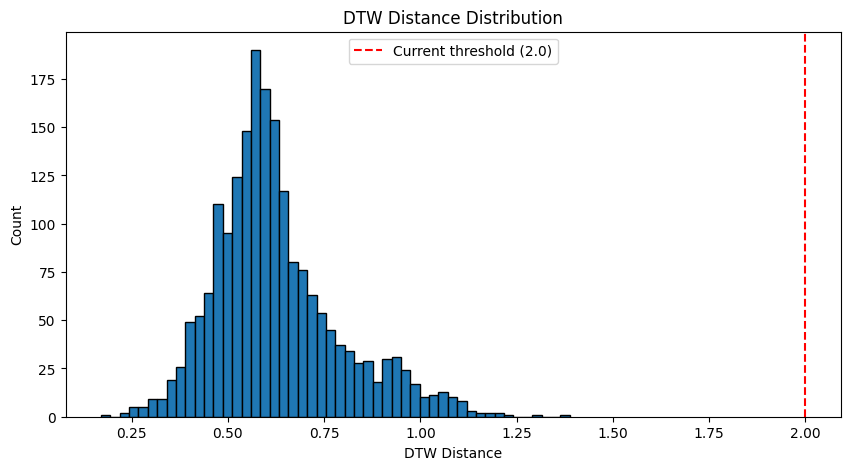

In [14]:
# 1. 먼저 DTW 분포 확인
pairs_with_dtw_info = find_comovement_pairs(
    pivot,
    max_lag=9,
    min_nonzero=12,
    corr_threshold=0.4,
    score_threshold=35,
    use_dtw=True,
    dtw_threshold=999  # 일단 전부 통과시키고
)

# DTW 거리 분포 확인
print("=== DTW Distance 분포 ===")
print(pairs_with_dtw_info['dtw_distance'].describe())
print(f"\n25th percentile: {pairs_with_dtw_info['dtw_distance'].quantile(0.25)}")
print(f"50th percentile (median): {pairs_with_dtw_info['dtw_distance'].quantile(0.50)}")
print(f"75th percentile: {pairs_with_dtw_info['dtw_distance'].quantile(0.75)}")

# 히스토그램으로 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(pairs_with_dtw_info['dtw_distance'], bins=50, edgecolor='black')
plt.xlabel('DTW Distance')
plt.ylabel('Count')
plt.title('DTW Distance Distribution')
plt.axvline(x=2.0, color='r', linestyle='--', label='Current threshold (2.0)')
plt.legend()
plt.show()

상관계수(corr_threshold=0.3)를 통과한 쌍들의 dtw분포, 즉 패턴 유사도를 보여줌



---



In [15]:
import os
import datetime

# result 폴더 생성 (이미 있으면 무시)
os.makedirs('./result', exist_ok=True)
date_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# 파일 저장
file_name = f'./result/sy_{date_str}.csv'
submission.to_csv(file_name, index=False)

# 옵션1 - 네트워크 구조로 pair를 필터링 한다음 학습하는 코드 (성능개선됨, 0.369대)

In [ ]:
import datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from tqdm import tqdm

train = pd.read_csv('train.csv')

# --- 데이터 전처리 (변경 없음) ---
monthly = (
    train
    .groupby(["item_id", "year", "month"], as_index=False)["value"]
    .sum()
)
monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2)
)
pivot = (
    monthly
    .pivot(index="item_id", columns="ym", values="value")
    .fillna(0.0)
)
months_dt = pivot.columns.to_list()  # 월(datetime) 리스트

# [중요] Stage1 결과로, 그래프 기반으로 재가중치/필터링된 pairs 사용
print("--- '원본 값 + 그래프 재가중치' 기반 공행성 쌍 사용 시작 ---")
pairs = pairs_for_model  # ✅ 여기만 기존 pairs_with_dtw 대신 pairs_for_model

print("최종 사용 공행성쌍 수:", len(pairs))


# --- (2. 학습 데이터 구축 - 피처 엔지니어링: 기존 28개 그대로) ---
def build_training_data_optimized(pivot, pairs, months_dt):
    """기존 28개 피처 구조 + pair 필터링만 변경"""
    months = months_dt
    n_months = len(months)
    rows = []

    for row in pairs.itertuples(index=False):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        for t in range(max(lag, 12), n_months - 1):
            b_t = b_series[t]
            b_t_1 = b_series[t - 1]
            b_t_2 = b_series[t - 2]
            b_t_12 = b_series[t - 12]
            a_t_lag = a_series[t - lag]
            b_t_plus_1 = b_series[t + 1]

            target_month = months[t + 1].month

            # 1. 선행 품목(A) 트렌드
            a_t_lag_diff = a_series[t - lag] - a_series[t - lag - 1]
            a_momentum = a_series[t - lag] / (a_series[t - lag - 3] + 1)
            a_roll_mean_3 = (a_series[t-lag] + a_series[t-lag-1] + a_series[t-lag-2]) / 3

            # 2. 후행 품목(B) 트렌드
            b_diff = b_t - b_t_1
            b_pct_change = (b_t - b_t_1) / (b_t_1 + 1)
            b_yoy_growth = (b_t - b_t_12) / (b_t_12 + 1)
            b_roll_mean_3 = (b_series[t] + b_series[t-1] + b_series[t-2]) / 3
            b_roll_mean_6 = (b_series[t-5:t+1]).mean()
            b_roll_std_3 = np.std([b_series[t], b_series[t-1], b_series[t-2]])

            # 3. A-B 상호작용
            ab_ratio = a_t_lag / (b_t + 1)
            ab_diff = a_t_lag - b_t
            corr_weighted_a = a_t_lag * corr

            # 4. 추가 고급 피처 (5개)
            b_cv = b_roll_std_3 / (b_roll_mean_3 + 1)
            b_acceleration = (b_t - b_t_1) - (b_t_1 - b_t_2)
            b_yoy_ratio = b_t / (b_t_12 + 1)
            b_ma_ratio = b_roll_mean_3 / (b_roll_mean_6 + 1)
            recent_12 = b_series[max(0, t-11):t+1]
            b_percentile_rank = (b_t >= recent_12).sum() / len(recent_12)

            # 5. 계절성
            quarter = (target_month - 1) // 3 + 1
            is_year_end = 1 if target_month in [11, 12, 1] else 0

            # 6. Lag 가중치
            lag_weight = 1 / (1 + lag)

            rows.append({
                # 기본 (7개)
                "b_t": b_t,
                "b_t_1": b_t_1,
                "b_t_12": b_t_12,
                "a_t_lag": a_t_lag,
                "max_corr": corr,
                "best_lag": float(lag),
                "month": float(target_month),

                # A 트렌드 (3개)
                "a_t_lag_diff": a_t_lag_diff,
                "a_momentum": a_momentum,
                "a_roll_mean_3": a_roll_mean_3,

                # B 트렌드 (6개)
                "b_diff": b_diff,
                "b_pct_change": b_pct_change,
                "b_yoy_growth": b_yoy_growth,
                "b_roll_mean_3": b_roll_mean_3,
                "b_roll_mean_6": b_roll_mean_6,
                "b_roll_std_3": b_roll_std_3,

                # 상호작용 (3개)
                "ab_ratio": ab_ratio,
                "ab_diff": ab_diff,
                "corr_weighted_a": corr_weighted_a,

                # 추가 고급 피처 (5개)
                "b_cv": b_cv,
                "b_acceleration": b_acceleration,
                "b_yoy_ratio": b_yoy_ratio,
                "b_ma_ratio": b_ma_ratio,
                "b_percentile_rank": b_percentile_rank,

                # 계절성 (2개)
                "quarter": float(quarter),
                "is_year_end": is_year_end,

                # Lag (1개)
                "lag_weight": lag_weight,

                "target": b_t_plus_1,
            })

    return pd.DataFrame(rows)


df_train_model = build_training_data_optimized(pivot, pairs, months_dt)
print('생성된 학습 데이터의 shape :', df_train_model.shape)


# --- (3. 회귀모델 학습 - 피처 리스트: 기존 28개 그대로) ---
feature_cols = [
    # 기본 (7개)
    'b_t', 'b_t_1', 'b_t_12', 'a_t_lag', 'max_corr', 'best_lag', 'month',

    # A 트렌드 (3개)
    'a_t_lag_diff', 'a_momentum', 'a_roll_mean_3',

    # B 트렌드 (6개)
    'b_diff', 'b_pct_change', 'b_yoy_growth',
    'b_roll_mean_3', 'b_roll_mean_6', 'b_roll_std_3',

    # 상호작용 (3개)
    'ab_ratio', 'ab_diff', 'corr_weighted_a',

    # 추가 고급 피처 (5개)
    'b_cv', 'b_acceleration', 'b_yoy_ratio', 'b_ma_ratio', 'b_percentile_rank',

    # 계절성 (2개)
    'quarter', 'is_year_end',

    # Lag (1개)
    'lag_weight'
]

if df_train_model.empty:
    print("오류: 학습 데이터가 없습니다. (lag가 너무 크거나, t 시작점이 높을 수 있음)")
    submission = pd.DataFrame(columns=['leading_item_id', 'following_item_id', 'value'])
else:
    train_X = df_train_model[feature_cols].values
    train_y = df_train_model["target"].values

    reg = LGBMRegressor(
        random_state=42,
        n_estimators=700,
        learning_rate=0.01,
        max_depth=8,
        num_leaves=50,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_split_gain=0.01
    )
    print("LGBMRegressor 모델(고급 피처 + 그래프 기반 pair 필터링) 학습 시작...")
    print(f"총 피처 개수: {len(feature_cols)}개")
    reg.fit(train_X, train_y)
    print("모델 학습 완료.")


# --- (4. 예측 - 동일 28개 피처 구조) ---
def predict_optimized(pivot, pairs, reg, months_dt):
    """고급 피처(28개) 기반 예측, pair는 그래프 재가중치 결과 사용"""
    months = months_dt
    n_months = len(months)
    t_last = n_months - 1
    t_prev = n_months - 2
    preds = []

    target_month = months[-1].month + 1 if months[-1].month < 12 else 1

    for row in tqdm(pairs.itertuples(index=False)):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        if t_last - lag < 0 or t_last < 12:
            continue

        b_t = b_series[t_last]
        b_t_1 = b_series[t_prev]
        b_t_2 = b_series[t_prev - 1]
        b_t_12 = b_series[t_last - 12]
        a_t_lag = a_series[t_last - lag]

        # A 트렌드
        a_t_lag_diff = a_series[t_last - lag] - a_series[t_last - lag - 1]
        a_momentum = a_series[t_last - lag] / (a_series[t_last - lag - 3] + 1)
        a_roll_mean_3 = (a_series[t_last-lag] + a_series[t_last-lag-1] + a_series[t_last-lag-2]) / 3

        # B 트렌드
        b_diff = b_t - b_t_1
        b_pct_change = (b_t - b_t_1) / (b_t_1 + 1)
        b_yoy_growth = (b_t - b_t_12) / (b_t_12 + 1)
        b_roll_mean_3 = (b_series[t_last] + b_series[t_last-1] + b_series[t_last-2]) / 3
        b_roll_mean_6 = b_series[t_last-5:t_last+1].mean()
        b_roll_std_3 = np.std([b_series[t_last], b_series[t_last-1], b_series[t_last-2]])

        # 상호작용
        ab_ratio = a_t_lag / (b_t + 1)
        ab_diff = a_t_lag - b_t
        corr_weighted_a = a_t_lag * corr

        # 추가 고급 피처 (5개)
        b_cv = b_roll_std_3 / (b_roll_mean_3 + 1)
        b_acceleration = (b_t - b_t_1) - (b_t_1 - b_t_2)
        b_yoy_ratio = b_t / (b_t_12 + 1)
        b_ma_ratio = b_roll_mean_3 / (b_roll_mean_6 + 1)
        recent_12 = b_series[max(0, t_last-11):t_last+1]
        b_percentile_rank = (b_t >= recent_12).sum() / len(recent_12)

        # 계절성
        quarter = (target_month - 1) // 3 + 1
        is_year_end = 1 if target_month in [11, 12, 1] else 0

        # Lag
        lag_weight = 1 / (1 + lag)

        X_test = np.array([[
            b_t, b_t_1, b_t_12, a_t_lag, corr, float(lag), float(target_month),
            a_t_lag_diff, a_momentum, a_roll_mean_3,
            b_diff, b_pct_change, b_yoy_growth, b_roll_mean_3, b_roll_mean_6, b_roll_std_3,
            ab_ratio, ab_diff, corr_weighted_a,
            b_cv, b_acceleration, b_yoy_ratio, b_ma_ratio, b_percentile_rank,
            float(quarter), is_year_end,
            lag_weight
        ]])

        y_pred = reg.predict(X_test)[0]
        y_pred = max(0.0, float(y_pred))
        y_pred = int(round(y_pred))

        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": y_pred,
        })

    return pd.DataFrame(preds)

if df_train_model.empty:
    print("학습된 모델이 없어 예측을 건너뜁니다.")
else:
    print("--- '고급 피처 + 그래프 기반 pair 필터링' 모델 예측 시작 ---")
    submission = predict_optimized(pivot, pairs, reg, months_dt)
    print(submission.head())

date_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f'./result/hs_advanced_{date_str}.csv'
submission.to_csv(file_name, index=False)

print(f"✓ 파일 저장 완료: {file_name}")
print(f"LGBM(고급 피처 + 그래프 기반 pair 필터링) 모델 예측 완료. {file_name}.csv 저장됨.")

--- '원본 값 + 그래프 재가중치' 기반 공행성 쌍 사용 시작 ---
최종 사용 공행성쌍 수: 2888
생성된 학습 데이터의 shape : (86640, 28)
LGBMRegressor 모델(고급 피처 + 그래프 기반 pair 필터링) 학습 시작...
총 피처 개수: 27개
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5408
[LightGBM] [Info] Number of data points in the train set: 86640, number of used features: 27
[LightGBM] [Info] Start training from score 4248595.480840
모델 학습 완료.
--- '고급 피처 + 그래프 기반 pair 필터링' 모델 예측 시작 ---


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/pyth

  leading_item_id following_item_id     value
0        AANGBULD          NAQIHUKZ     43132
1        AANGBULD          GKQIJYDH  11936305
2        AANGBULD          FTSVTTSR    191046
3        AANGBULD          ZKENOUDA    334817
4        AANGBULD          ZCELVYQU    197561
✓ 파일 저장 완료: ./result/hs_advanced_20251121_081722.csv
LGBM(고급 피처 + 그래프 기반 pair 필터링) 모델 예측 완료. ./result/hs_advanced_20251121_081722.csv.csv 저장됨.


# 옵션2 - 그래프 기반 정보 추가 학습 코드 (이 정보를 모델링에 넣을 FEATURE로 쓰기) <- 피처로 추가하니 성능이 떨어짐

In [16]:
# import datetime
# import pandas as pd
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from lightgbm import LGBMRegressor
# from tqdm import tqdm

# train = pd.read_csv("train.csv")

# # --- 데이터 전처리 (변경 없음) ---
# monthly = (
#     train
#     .groupby(["item_id", "year", "month"], as_index=False)["value"]
#     .sum()
# )
# monthly["ym"] = pd.to_datetime(
#     monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2)
# )
# pivot = (
#     monthly
#     .pivot(index="item_id", columns="ym", values="value")
#     .fillna(0.0)
# )
# months_dt = pivot.columns.to_list()  # 월(datetime) 리스트

# # 공행성쌍 (DTW 포함)
# print("--- '원본 값' 기반 공행성 쌍 탐색 시작 ---")
# pairs = pairs_with_dtw
# print("탐색된 공행성쌍 수:", len(pairs))


# # ============================================================
# # (2) 학습 데이터 구축 — 여기서 “그래프 피처 3개만” 사용
# # ============================================================
# def build_training_data_optimized(pivot, pairs, months_dt):
#     months = months_dt
#     n_months = len(months)
#     rows = []

#     for row in pairs.itertuples(index=False):
#         leader = row.leading_item_id
#         follower = row.following_item_id
#         lag = int(row.best_lag)
#         corr = float(row.max_corr)

#         # ===== 그래프 기반 최종 선택된 3개 feature =====
#         same_comm  = float(row.same_comm)
#         deg_ratio  = float(row.deg_ratio)
#         btwn_ratio = float(row.btwn_ratio)

#         if leader not in pivot.index or follower not in pivot.index:
#             continue

#         a_series = pivot.loc[leader].values.astype(float)
#         b_series = pivot.loc[follower].values.astype(float)

#         for t in range(max(lag, 12), n_months - 1):
#             b_t = b_series[t]
#             b_t_1 = b_series[t - 1]
#             b_t_2 = b_series[t - 2]
#             b_t_12 = b_series[t - 12]
#             a_t_lag = a_series[t - lag]
#             b_t_plus_1 = b_series[t + 1]

#             target_month = months[t + 1].month

#             # 기존 피처 원형 유지
#             a_t_lag_diff = a_series[t - lag] - a_series[t - lag - 1]
#             a_momentum = a_series[t - lag] / (a_series[t - lag - 3] + 1)
#             a_roll_mean_3 = (a_series[t-lag] + a_series[t-lag-1] + a_series[t-lag-2]) / 3

#             b_diff = b_t - b_t_1
#             b_pct_change = (b_t - b_t_1) / (b_t_1 + 1)
#             b_yoy_growth = (b_t - b_t_12) / (b_t_12 + 1)
#             b_roll_mean_3 = (b_series[t] + b_series[t-1] + b_series[t-2]) / 3
#             b_roll_mean_6 = b_series[t-5:t+1].mean()
#             b_roll_std_3 = np.std([b_series[t], b_series[t-1], b_series[t-2]])

#             ab_ratio = a_t_lag / (b_t + 1)
#             ab_diff = a_t_lag - b_t
#             corr_weighted_a = a_t_lag * corr

#             b_cv = b_roll_std_3 / (b_roll_mean_3 + 1)
#             b_acceleration = (b_t - b_t_1) - (b_t_1 - b_t_2)
#             b_yoy_ratio = b_t / (b_t_12 + 1)
#             b_ma_ratio = b_roll_mean_3 / (b_roll_mean_6 + 1)
#             recent_12 = b_series[max(0, t-11):t+1]
#             b_percentile_rank = (b_t >= recent_12).sum() / len(recent_12)

#             quarter = (target_month - 1) // 3 + 1
#             is_year_end = 1 if target_month in [11, 12, 1] else 0
#             lag_weight = 1 / (1 + lag)

#             rows.append({
#                 # 기존 28개 피처
#                 "b_t": b_t,
#                 "b_t_1": b_t_1,
#                 "b_t_12": b_t_12,
#                 "a_t_lag": a_t_lag,
#                 "max_corr": corr,
#                 "best_lag": float(lag),
#                 "month": float(target_month),

#                 "a_t_lag_diff": a_t_lag_diff,
#                 "a_momentum": a_momentum,
#                 "a_roll_mean_3": a_roll_mean_3,

#                 "b_diff": b_diff,
#                 "b_pct_change": b_pct_change,
#                 "b_yoy_growth": b_yoy_growth,
#                 "b_roll_mean_3": b_roll_mean_3,
#                 "b_roll_mean_6": b_roll_mean_6,
#                 "b_roll_std_3": b_roll_std_3,

#                 "ab_ratio": ab_ratio,
#                 "ab_diff": ab_diff,
#                 "corr_weighted_a": corr_weighted_a,

#                 "b_cv": b_cv,
#                 "b_acceleration": b_acceleration,
#                 "b_yoy_ratio": b_yoy_ratio,
#                 "b_ma_ratio": b_ma_ratio,
#                 "b_percentile_rank": b_percentile_rank,

#                 "quarter": float(quarter),
#                 "is_year_end": is_year_end,

#                 "lag_weight": lag_weight,

#                 # ===== 추가된 그래프 기반 피처 3개 =====
#                 "same_comm": same_comm,
#                 "deg_ratio": deg_ratio,
#                 "btwn_ratio": btwn_ratio,

#                 "target": b_t_plus_1,
#             })

#     return pd.DataFrame(rows)


# df_train_model = build_training_data_optimized(pivot, pairs, months_dt)
# print("생성된 학습 데이터 shape:", df_train_model.shape)


# # ============================================================
# # (3) Feature 리스트 — 총 31개 (28 + 3)
# # ============================================================
# feature_cols = [
#     'b_t','b_t_1','b_t_12','a_t_lag','max_corr','best_lag','month',
#     'a_t_lag_diff','a_momentum','a_roll_mean_3',
#     'b_diff','b_pct_change','b_yoy_growth',
#     'b_roll_mean_3','b_roll_mean_6','b_roll_std_3',
#     'ab_ratio','ab_diff','corr_weighted_a',
#     'b_cv','b_acceleration','b_yoy_ratio','b_ma_ratio','b_percentile_rank',
#     'quarter','is_year_end',
#     'lag_weight',

#     # 그래프 기반 핵심 3개
#     'same_comm', 'deg_ratio', 'btwn_ratio'
# ]


# # ============================================================
# # (4) 모델 학습
# # ============================================================
# if df_train_model.empty:
#     print("학습 데이터가 비어있습니다.")
#     submission = pd.DataFrame(columns=['leading_item_id','following_item_id','value'])
# else:
#     train_X = df_train_model[feature_cols].values
#     train_y = df_train_model["target"].values

#     reg = LGBMRegressor(
#         random_state=42,
#         n_estimators=700,
#         learning_rate=0.01,
#         max_depth=8,
#         num_leaves=50,
#         min_child_samples=20,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         reg_alpha=0.1,
#         reg_lambda=0.1,
#         min_split_gain=0.01
#     )
#     print("LGBM 학습 시작...")
#     print(f"총 피처: {len(feature_cols)}개")
#     reg.fit(train_X, train_y)
#     print("모델 학습 완료.")


# # ============================================================
# # (5) 예측 코드 — 동일한 3개 그래프 피처 추가
# # ============================================================
# def predict_optimized(pivot, pairs, reg, months_dt):
#     months = months_dt
#     n_months = len(months)
#     t_last = n_months - 1
#     t_prev = n_months - 2
#     preds = []

#     target_month = months[-1].month + 1 if months[-1].month < 12 else 1

#     for row in tqdm(pairs.itertuples(index=False)):
#         leader = row.leading_item_id
#         follower = row.following_item_id
#         lag = int(row.best_lag)
#         corr = float(row.max_corr)

#         # 그래프 기반 3개
#         same_comm  = float(row.same_comm)
#         deg_ratio  = float(row.deg_ratio)
#         btwn_ratio = float(row.btwn_ratio)

#         if leader not in pivot.index or follower not in pivot.index:
#             continue

#         a_series = pivot.loc[leader].values.astype(float)
#         b_series = pivot.loc[follower].values.astype(float)

#         if t_last - lag < 0 or t_last < 12:
#             continue

#         b_t = b_series[t_last]
#         b_t_1 = b_series[t_prev]
#         b_t_2 = b_series[t_prev - 1]
#         b_t_12 = b_series[t_last - 12]
#         a_t_lag = a_series[t_last - lag]

#         # 기존 피처와 동일
#         a_t_lag_diff = a_series[t_last - lag] - a_series[t_last - lag - 1]
#         a_momentum = a_series[t_last - lag] / (a_series[t_last - lag - 3] + 1)
#         a_roll_mean_3 = (a_series[t_last-lag] + a_series[t_last-lag-1] + a_series[t_last-lag-2]) / 3

#         b_diff = b_t - b_t_1
#         b_pct_change = (b_t - b_t_1) / (b_t_1 + 1)
#         b_yoy_growth = (b_t - b_t_12) / (b_t_12 + 1)
#         b_roll_mean_3 = (b_series[t_last] + b_series[t_last-1] + b_series[t_last-2]) / 3
#         b_roll_mean_6 = b_series[t_last-5:t_last+1].mean()
#         b_roll_std_3 = np.std([b_series[t_last], b_series[t_last-1], b_series[t_last-2]])

#         ab_ratio = a_t_lag / (b_t + 1)
#         ab_diff = a_t_lag - b_t
#         corr_weighted_a = a_t_lag * corr

#         b_cv = b_roll_std_3 / (b_roll_mean_3 + 1)
#         b_acceleration = (b_t - b_t_1) - (b_t_1 - b_t_2)
#         b_yoy_ratio = b_t / (b_t_12 + 1)
#         b_ma_ratio = b_roll_mean_3 / (b_roll_mean_6 + 1)
#         recent_12 = b_series[max(0, t_last-11):t_last+1]
#         b_percentile_rank = (b_t >= recent_12).sum() / len(recent_12)

#         quarter = (target_month - 1) // 3 + 1
#         is_year_end = 1 if target_month in [11,12,1] else 0

#         lag_weight = 1 / (1 + lag)

#         X_test = np.array([[
#             b_t,b_t_1,b_t_12,a_t_lag,corr,float(lag),float(target_month),
#             a_t_lag_diff,a_momentum,a_roll_mean_3,
#             b_diff,b_pct_change,b_yoy_growth,b_roll_mean_3,b_roll_mean_6,b_roll_std_3,
#             ab_ratio,ab_diff,corr_weighted_a,
#             b_cv,b_acceleration,b_yoy_ratio,b_ma_ratio,b_percentile_rank,
#             float(quarter),is_year_end,
#             lag_weight,
#             same_comm,deg_ratio,btwn_ratio
#         ]])

#         y_pred = reg.predict(X_test)[0]
#         y_pred = max(0.0, float(y_pred))
#         y_pred = int(round(y_pred))

#         preds.append({
#             "leading_item_id": leader,
#             "following_item_id": follower,
#             "value": y_pred,
#         })

#     return pd.DataFrame(preds)



# if df_train_model.empty:
#     print("학습된 모델 없음 → 예측 skip")
# else:
#     print("--- 예측 시작 ---")
#     submission = predict_optimized(pivot, pairs, reg, months_dt)
#     print(submission.head())

# date_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
# file_name = f"./result/hs_advanced_{date_str}.csv"
# submission.to_csv(file_name, index=False)

# print(f"✓ 파일 저장 완료: {file_name}")
# print("LGBM (고급 + 그래프 feature 3개) 예측 완료.")

--- '원본 값' 기반 공행성 쌍 탐색 시작 ---
탐색된 공행성쌍 수: 3368
생성된 학습 데이터 shape: (101040, 31)
LGBM 학습 시작...
총 피처: 30개
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5919
[LightGBM] [Info] Number of data points in the train set: 101040, number of used features: 30
[LightGBM] [Info] Start training from score 4144408.771546
모델 학습 완료.
--- 예측 시작 ---


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
872it [00:01, 658.94it/s]/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.

  leading_item_id following_item_id     value
0        AANGBULD          ZCELVYQU    201402
1        AANGBULD          ZKENOUDA    336295
2        AANGBULD          DEWLVASR    336078
3        AANGBULD          NAQIHUKZ     52271
4        AANGBULD          GKQIJYDH  13658466
✓ 파일 저장 완료: ./result/hs_advanced_20251121_112537.csv
LGBM (고급 + 그래프 feature 3개) 예측 완료.
